<a href="https://colab.research.google.com/github/emmajhudgins/evidencesynthesis_forestpests/blob/main/stopwords.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stopwords


In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
def top_k_to_n(array, k=0, n=100):
  return [i for i in array[k:n].index]
  
def get_all_words(fn, sum_dest, word_dest):
  df = pd.read_csv(fn)
  all_text = list(df['all_text']) 
  # clean the text
  cleaned = [re.sub('[^0-9a-zA-Z ]+', '', t) if type(t) == type("a") else '' for t in all_text ]
  # calculate the count
  vectorizer =CountVectorizer(max_features = 10000, lowercase = True, ngram_range = (1,2), stop_words='english')
  vec = vectorizer.fit_transform(cleaned)
  dense_vec = vec.todense().tolist()
  names = vectorizer.get_feature_names() # get the words
  df_v = pd.DataFrame(dense_vec, columns=names)
  # sum all the count of each word in each article
  sum_w = df_v.T.sum(axis=1)
  sum_w = sum_w.sort_values(ascending=False)
  sum_w.to_csv(sum_dest)
  # get the top k to n words
  top = top_k_to_n(sum_w)
  with open(word_dest, 'w') as f:
    for item in top:
        f.write("%s\n" % item)


In [ ]:
get_all_words('gr_usa.csv', 'gr_usa_sum.csv','gr_usa_top100.txt')

# LDA

code adapted from https://towardsdatascience.com/topic-modeling-with-latent-dirichlet-allocation-by-example-3b22cd10c835

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from datetime import datetime
import nltk
nltk.download('stopwords')
import pandas as pd
import re
import math


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
fn = 'review_text.csv'
df = pd.read_csv(fn)
all_text = list(df['all_text']) 
cleaned = [re.sub('[^0-9a-zA-Z ]+', '', t) for t in all_text]
cleaned = [s.lower() for s in cleaned]


In [ ]:
custom_sw = [  
    "et", 
    "al",  
    "north", 
    "2010", 
    "2014", 
    "2015", 
    "2012", 
    "2017", 
    "2006", 
    "2007", 
    "2009", 
    "2011", 
    "2008", 
    "2013",
    "2016"
]

In [ ]:
all_stopwords = stopwords.words('english') + custom_sw
tokens = [s.split() for s in cleaned]
tokens_wo_sw = [[t for t in token if t not in stopwords_all] for token in tokens]


In [ ]:

def get_most_freq_words(str, n=None):
    vect = CountVectorizer().fit(str)
    bag_of_words = vect.transform(str)
    sum_words = bag_of_words.sum(axis=0) 
    freq = [(word, sum_words[0, idx]) for word, idx in vect.vocabulary_.items()]
    freq =sorted(freq, key = lambda x: x[1], reverse=True)
    return freq[:n]
  
get_most_freq_words([ word for token in tokens_wo_sw for word in token],10)

[('species', 3665),
 ('forest', 3471),
 ('trees', 2260),
 ('ash', 1996),
 ('forests', 1429),
 ('new', 1309),
 ('control', 1269),
 ('plant', 1239),
 ('management', 1225),
 ('pine', 1222)]

In [ ]:
tokens_dictionary = Dictionary(tokens_wo_sw)

In [ ]:
tokens_corpus = [tokens_dictionary.doc2bow(t) for t in tokens_wo_sw]

# compute coherence
tokens_coherence = []
for nb_topics in range(1,15):
    lda = LdaModel(tokens_corpus, num_topics = nb_topics, id2word = tokens_dictionary, passes=10)
    cohm = CoherenceModel(model=lda, corpus=tokens_corpus, dictionary=tokens_dictionary, coherence='u_mass')
    coh = cohm.get_coherence()
    tokens_coherence.append(coh)


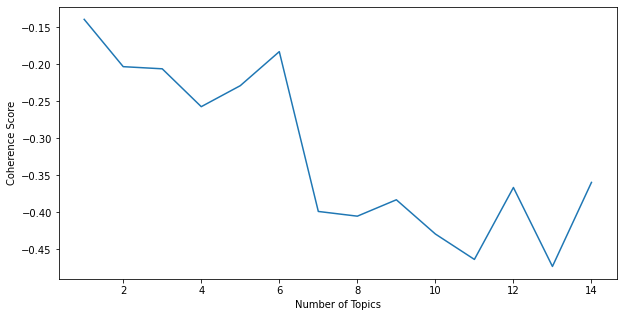

In [ ]:
import matplotlib.pyplot as plt

# visualize coherence
plt.figure(figsize=(10,5))
plt.plot(range(1,15),tokens_coherence)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score");

In [ ]:

k = 6
tokens_lda = LdaModel(tokens_corpus, num_topics = k, id2word = tokens_dictionary, passes=10)


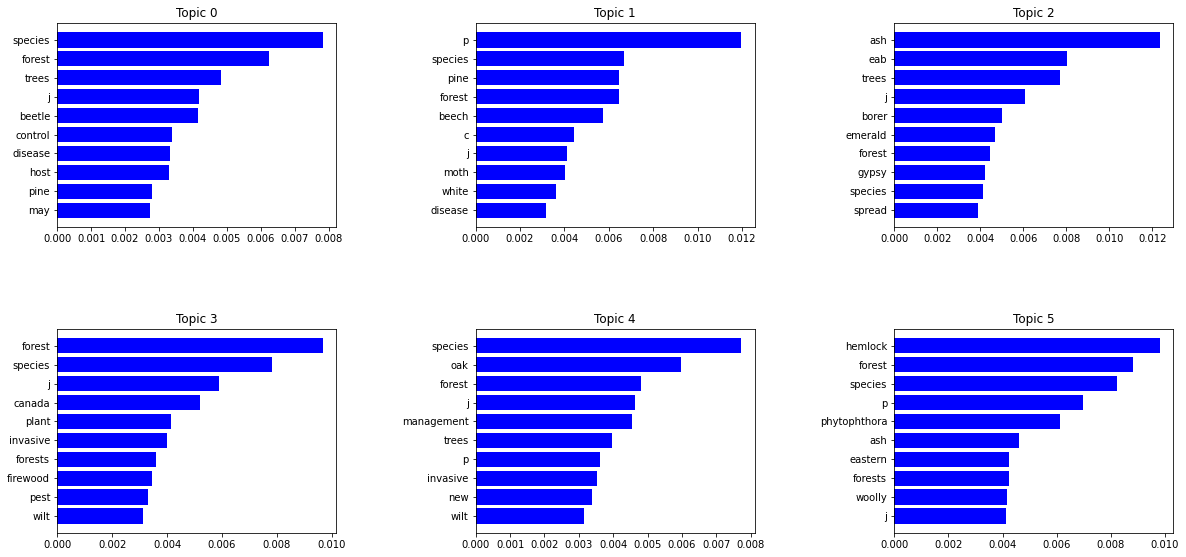

In [ ]:
import matplotlib.gridspec as gridspec
def plot_top_words(lda=tokens_lda, nb_topics=k, nb_words=10):
    top_words = [[word for word,_ in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    top_betas = [[beta for _,beta in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]

    gs  = gridspec.GridSpec(round(math.sqrt(k))+1,round(math.sqrt(k))+1)
    gs.update(wspace=0.5, hspace=0.5)
    plt.figure(figsize=(20,15))
    for i in range(nb_topics):
        ax = plt.subplot(gs[i])
        plt.barh(range(nb_words), top_betas[i][:nb_words], align='center',color='blue', ecolor='black')
        ax.invert_yaxis()
        ax.set_yticks(range(nb_words))
        ax.set_yticklabels(top_words[i][:nb_words])
        plt.title("Topic "+str(i))
        
  
plot_top_words()